In [1]:
import mitsuba as mi
mi.set_variant('scalar_rgb')
tent_rfilter = mi.load_dict({'type' : 'tent'})
mi.set_variant("cuda_ad_rgb")
import drjit as dr
from enum import Enum

import matplotlib.pyplot as plt
%config InlineBackend.figure_formats = ['svg']
%matplotlib inline
import numpy as np

mi.Thread.thread().logger().set_log_level(mi.LogLevel.Error)

In [2]:
class Scene(Enum):
    COND1 = 1
    COND2 = 2

In [3]:
OPT_ROUGH_KEY = 'plane.bsdf.alpha.data'
OPT_ENVLIGHT_KEY = 'emitter.data'

# Utils

In [4]:
def to_float(x):
    # hacky way to convert Mitsuba float to Python float
    return float(np.array(x))

In [5]:
def plot_res(images_bm, rough_bm, envlight_bm, titles, size_factor=3):
    fig, ax = plt.subplots(ncols=3, nrows=len(images_bm), figsize=(8, size_factor*len(images_bm)), squeeze=False)
    for i, (img, tex, envlight, title) in enumerate(zip(images_bm, rough_bm, envlight_bm, titles)):
        ax[i, 0].imshow(img)
        ax[i, 1].imshow(tex)
        ax[i, 2].imshow(envlight)
        ax[i, 0].set_ylabel(title, size=14)
        ax[i, 0].set_xticks([]); ax[i, 0].set_yticks([])
        ax[i, 1].set_xticks([]); ax[i, 1].set_yticks([])
        ax[i, 2].set_xticks([]); ax[i, 2].set_yticks([])
    ax[0, 0].set_title("Rendering", weight='bold', size=14)
    ax[0, 1].set_title("Roughness texture", weight='bold', size=14)
    ax[0, 2].set_title("Environment light", weight='bold', size=14)
    plt.tight_layout()
    plt.show()

def plot_res2(res_dict, size_factor=3):
    titles = list(res_dict.keys())
    images_bm = [res_dict[title][0] for title in titles]
    textures_bm = [res_dict[title][1] for title in titles]
    envlights_bm = [res_dict[title][2] for title in titles]
    plot_res(images_bm, textures_bm, envlights_bm, titles, size_factor)

In [6]:
def image_to_bm(image):
    return mi.util.convert_to_bitmap(image)

def params_to_bm(params):
    return mi.util.convert_to_bitmap(params).convert(mi.Bitmap.PixelFormat.RGB, mi.Struct.Type.UInt8, False)

In [7]:
def reset_scene(scene: Scene):
    return mi.load_file(f"../scenes/roughness_optimization_{scene.value}.xml")

In [8]:
def generate_rand_rough_tex(scene_name: Scene, seed=0):
    init_res = 32
    scale = 0.5 if scene_name == Scene.COND1 else 0.3
    opt_res = 512

    # Initialize textured roughness with random values
    np.random.seed(seed)
    initial_values = mi.Bitmap((scale*np.random.uniform(size=init_res**2)).reshape(init_res, init_res, -1))

    # Upsample texture to full resolution
    return mi.TensorXf(np.array(initial_values.resample([opt_res, opt_res], tent_rfilter))[..., np.newaxis])

In [9]:
def generate_rand_envlight(scene_name: Scene, seed=0):
    init_res = 32
    scale = 0.5 if scene_name == Scene.COND1 else 0.3

    # Initialize textured roughness with random values
    np.random.seed(seed)
    initial_values = mi.Bitmap((scale*np.random.uniform(size=2*init_res**2*4)).reshape(2*init_res, init_res, -1))

    # Upsample texture to full resolution
    upsampled_values = np.array(initial_values.resample([513, 256], tent_rfilter))
    upsampled_values = mi.TensorXf(upsampled_values)

    return upsampled_values

In [10]:
def generate_rand_init_values(scene_name: Scene, seed = 0):
    rough_values = generate_rand_rough_tex(scene_name, seed)
    envlight_values = generate_rand_envlight(scene_name, seed)
    return {OPT_ROUGH_KEY: rough_values, OPT_ENVLIGHT_KEY: envlight_values}

# Reference scenes rendering

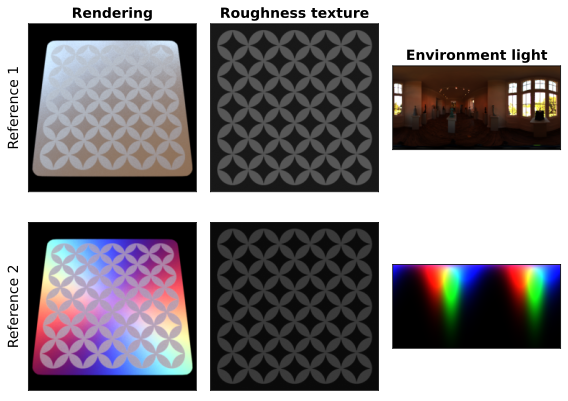

In [11]:
scene_ref = {k: reset_scene(k) for k in Scene}
params = {k: mi.traverse(scene_ref[k]) for k in Scene}

# Render reference images
image_ref = {k: mi.render(scene_ref[k], seed=0, spp=128) for k in Scene}
params_rough_ref = {k: params[k][OPT_ROUGH_KEY] for k in Scene}
params_envlight_ref = {k: params[k][OPT_ENVLIGHT_KEY] for k in Scene}

image_ref_bm = {k: image_to_bm(image_ref[k])  for k in Scene}
params_rough_ref_bm = {k: params_to_bm(params_rough_ref[k])  for k in Scene}
params_envlight_ref_bm = {k: params_to_bm(params_envlight_ref[k])  for k in Scene}

# Plot
plot_res2({f'Reference {k.value}': (image_ref_bm[k], params_rough_ref_bm[k], params_envlight_ref_bm[k]) for k in Scene})

# Loss landscape utils

In [12]:
def rel_l1_loss(img, img_ref):
    # Relative L1 loss
    return dr.sum(dr.abs(img - img_ref) / (dr.maximum(dr.abs(img_ref), 0.001))) / len(img)

def mse(img, img_ref):
    return dr.mean(dr.sqr(img - img_ref))

In [13]:
def plot_loss_linear_interp_1D(scene_name: Scene, params_1, params_2, loss_fn=rel_l1_loss, n_samples = 100, title=None, spp=8):
    alphas = np.linspace(0, 1, n_samples)
    losses = []
    for i, alpha in enumerate(alphas):
        scene = reset_scene(scene_name)
        params = mi.traverse(scene)
        params[OPT_ROUGH_KEY] = (1 - alpha) * params_1[OPT_ROUGH_KEY] + alpha * params_2[OPT_ROUGH_KEY]
        params[OPT_ENVLIGHT_KEY] = (1 - alpha) * params_1[OPT_ENVLIGHT_KEY] + alpha * params_2[OPT_ENVLIGHT_KEY]
        params.update()
        image = mi.render(scene, params, seed=i, spp=spp)
        losses.append(loss_fn(image, image_ref[scene_name]))
    if title is not None:
        plt.title(title)
    plt.plot(alphas, losses)

In [14]:
def plot_loss_bilinear_interp_2D(
    scene_name: Scene,
    params_1,
    params_2,
    params_3,
    params_4,
    loss_fn=rel_l1_loss,
    n_samples=10,
    title=None,
    spp=8,
):
    alphas = np.linspace(0, 1, n_samples)
    losses = np.zeros((n_samples, n_samples))
    for i, alpha in enumerate(alphas):
        for j, beta in enumerate(alphas):
            scene = reset_scene(scene_name)
            params = mi.traverse(scene)
            params[OPT_ROUGH_KEY] = (
                (1 - alpha) * (1 - beta) * params_1[OPT_ROUGH_KEY]
                + (1 - alpha) * beta * params_2[OPT_ROUGH_KEY]
                + alpha * (1 - beta) * params_3[OPT_ROUGH_KEY]
                + alpha * beta * params_4[OPT_ROUGH_KEY]
            )
            params[OPT_ENVLIGHT_KEY] = (
                (1 - alpha) * (1 - beta) * params_1[OPT_ENVLIGHT_KEY]
                + (1 - alpha) * beta * params_2[OPT_ENVLIGHT_KEY]
                + alpha * (1 - beta) * params_3[OPT_ENVLIGHT_KEY]
                + alpha * beta * params_4[OPT_ENVLIGHT_KEY]
            )
            params.update()
            image = mi.render(scene, params, seed=i * len(alphas) + j, spp=spp)
            losses[i, j] = to_float(loss_fn(image, image_ref[scene_name]))
    if title is not None:
        plt.title(title)
    plt.contourf(alphas, alphas, losses)
    plt.colorbar()


In [15]:
def contour_plot_1d(scene_name: Scene, params, dir, loss_fn=rel_l1_loss, n_samples = 100, title=None, spp=8):
    alphas = np.linspace(0, 1, n_samples)
    losses = []
    for i, alpha in enumerate(alphas):
        scene = reset_scene(scene_name)
        params_loc = mi.traverse(scene)
        params_loc[OPT_ROUGH_KEY] = params[OPT_ROUGH_KEY] + alpha * dir[OPT_ROUGH_KEY]
        params_loc[OPT_ENVLIGHT_KEY] = params[OPT_ENVLIGHT_KEY] + alpha * dir[OPT_ENVLIGHT_KEY]
        params_loc.update()
        image = mi.render(scene, params_loc, seed=i, spp=spp)
        losses.append(loss_fn(image, image_ref[scene_name]))
    if title is not None:
        plt.title(title)
    plt.plot(alphas, losses)

In [16]:
def contour_plot_2d(scene_name: Scene, params, dir1, dir2, loss_fn=rel_l1_loss, n_samples = 10, title=None, spp=8):
    # TODO check that the labels are correct
    alphas = np.linspace(0, 1, n_samples)
    losses = np.zeros((n_samples, n_samples))
    for i, alpha in enumerate(alphas):
        for j, beta in enumerate(alphas):
            scene = reset_scene(scene_name)
            params_loc = mi.traverse(scene)
            params_loc[OPT_ROUGH_KEY] = dr.clamp(params[OPT_ROUGH_KEY] + alpha * dir1[OPT_ROUGH_KEY] + beta * dir2[OPT_ROUGH_KEY], 0.0, 1.0)
            params_loc[OPT_ENVLIGHT_KEY] = dr.clamp(params[OPT_ENVLIGHT_KEY] + alpha * dir1[OPT_ENVLIGHT_KEY] + beta * dir2[OPT_ENVLIGHT_KEY], 0.0, 1.0)
            params_loc.update()
            image = mi.render(scene, params_loc, seed=i*len(alphas)+j, spp=spp)
            losses[i, j] = to_float(loss_fn(image, image_ref[scene_name]))
    if title is not None:
        plt.title(title)
    plt.xlabel('dir1')
    plt.ylabel('dir2')
    plt.contourf(alphas, alphas, losses)
    plt.colorbar()

# Interp 1D experiments

## Scene 1

In [17]:
params_envlight_ref[Scene.COND1].shape

(256, 513, 4)

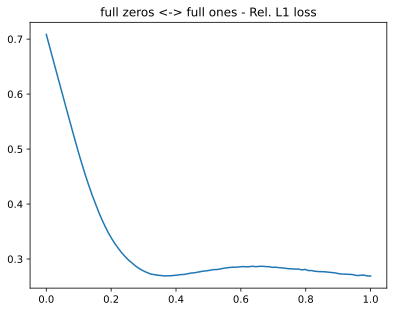

In [18]:
params_1 = {
    OPT_ROUGH_KEY: mi.TensorXf(np.zeros((512, 512, 1))),
    OPT_ENVLIGHT_KEY: mi.TensorXf(np.zeros((256, 513, 4))),
}
params_2 = {
    OPT_ROUGH_KEY: mi.TensorXf(np.ones((512, 512, 1))),
    OPT_ENVLIGHT_KEY: mi.TensorXf(np.ones((256, 513, 4))),
}
plot_loss_linear_interp_1D(Scene.COND1, params_1, params_2, title="full zeros <-> full ones - Rel. L1 loss", loss_fn=rel_l1_loss)

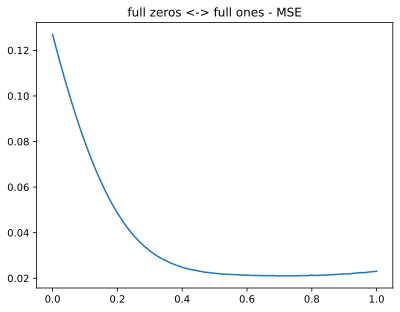

In [19]:
params_1 = {
    OPT_ROUGH_KEY: mi.TensorXf(np.zeros((512, 512, 1))),
    OPT_ENVLIGHT_KEY: mi.TensorXf(np.zeros((256, 513, 4))),
}
params_2 = {
    OPT_ROUGH_KEY: mi.TensorXf(np.ones((512, 512, 1))),
    OPT_ENVLIGHT_KEY: mi.TensorXf(np.ones((256, 513, 4))),
}
plot_loss_linear_interp_1D(Scene.COND1, params_1, params_2, title="full zeros <-> full ones - MSE", loss_fn=mse)

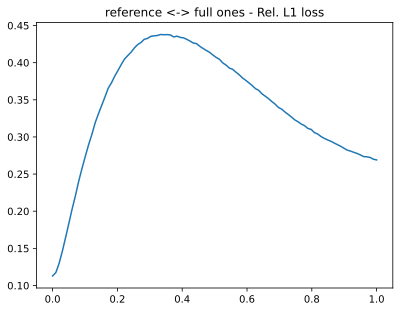

In [20]:
params_1 = {
    OPT_ROUGH_KEY: mi.TensorXf(params_rough_ref[Scene.COND1]),
    OPT_ENVLIGHT_KEY: mi.TensorXf(params_envlight_ref[Scene.COND1]),
}
params_2 = {
    OPT_ROUGH_KEY: mi.TensorXf(np.ones((512, 512, 1))),
    OPT_ENVLIGHT_KEY: mi.TensorXf(np.ones((256, 513, 4))),
}
plot_loss_linear_interp_1D(Scene.COND1, params_1, params_2, title="reference <-> full ones - Rel. L1 loss", loss_fn=rel_l1_loss)

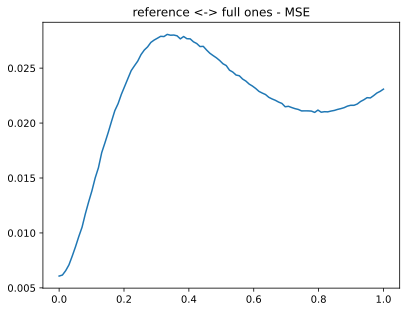

In [21]:
params_1 = {
    OPT_ROUGH_KEY: mi.TensorXf(params_rough_ref[Scene.COND1]),
    OPT_ENVLIGHT_KEY: mi.TensorXf(params_envlight_ref[Scene.COND1]),
}
params_2 = {
    OPT_ROUGH_KEY: mi.TensorXf(np.ones((512, 512, 1))),
    OPT_ENVLIGHT_KEY: mi.TensorXf(np.ones((256, 513, 4))),
}
plot_loss_linear_interp_1D(Scene.COND1, params_1, params_2, title="reference <-> full ones - MSE", loss_fn=mse)

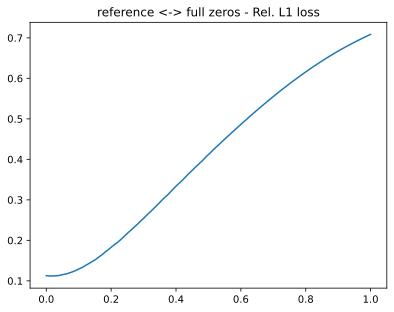

In [22]:
params_1 = {
    OPT_ROUGH_KEY: mi.TensorXf(params_rough_ref[Scene.COND1]),
    OPT_ENVLIGHT_KEY: mi.TensorXf(params_envlight_ref[Scene.COND1]),
}
params_2 = {
    OPT_ROUGH_KEY: mi.TensorXf(np.zeros((512, 512, 1))),
    OPT_ENVLIGHT_KEY: mi.TensorXf(np.zeros((256, 513, 4))),
}
plot_loss_linear_interp_1D(Scene.COND1, params_1, params_2, title="reference <-> full zeros - Rel. L1 loss", loss_fn=rel_l1_loss)

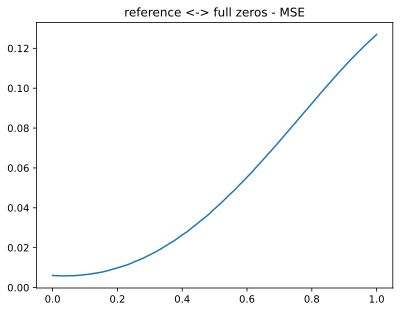

In [23]:
params_1 = {
    OPT_ROUGH_KEY: mi.TensorXf(params_rough_ref[Scene.COND1]),
    OPT_ENVLIGHT_KEY: mi.TensorXf(params_envlight_ref[Scene.COND1]),
}
params_2 = {
    OPT_ROUGH_KEY: mi.TensorXf(np.zeros((512, 512, 1))),
    OPT_ENVLIGHT_KEY: mi.TensorXf(np.zeros((256, 513, 4))),
}
plot_loss_linear_interp_1D(Scene.COND1, params_1, params_2, title="reference <-> full zeros - MSE", loss_fn=mse)

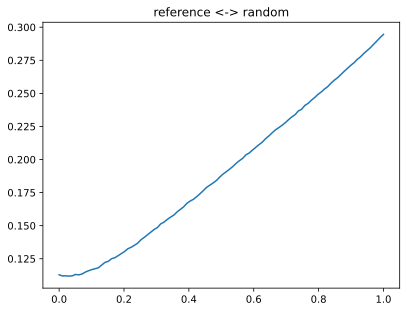

In [24]:
params_1 = {
    OPT_ROUGH_KEY: mi.TensorXf(params_rough_ref[Scene.COND1]),
    OPT_ENVLIGHT_KEY: mi.TensorXf(params_envlight_ref[Scene.COND1]),
}
params_2 = generate_rand_init_values(Scene.COND1, seed=0)
plot_loss_linear_interp_1D(Scene.COND1, params_1, params_2, title="reference <-> random")

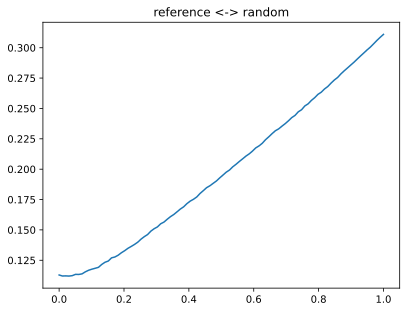

In [25]:
params_1 = {
    OPT_ROUGH_KEY: mi.TensorXf(params_rough_ref[Scene.COND1]),
    OPT_ENVLIGHT_KEY: mi.TensorXf(params_envlight_ref[Scene.COND1]),
}
params_2 = generate_rand_init_values(Scene.COND1, seed=1)
plot_loss_linear_interp_1D(Scene.COND1, params_1, params_2, title="reference <-> random")

## Scene 2

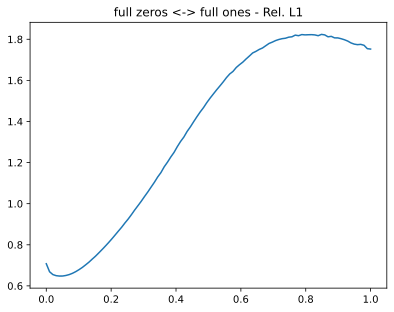

In [26]:
params_1 = {
    OPT_ROUGH_KEY: mi.TensorXf(np.zeros((512, 512, 1))),
    OPT_ENVLIGHT_KEY: mi.TensorXf(np.zeros((256, 513, 4))),
}
params_2 = {
    OPT_ROUGH_KEY: mi.TensorXf(np.ones((512, 512, 1))),
    OPT_ENVLIGHT_KEY: mi.TensorXf(np.ones((256, 513, 4))),
}
plot_loss_linear_interp_1D(Scene.COND2, params_1, params_2, title="full zeros <-> full ones - Rel. L1", loss_fn=rel_l1_loss)

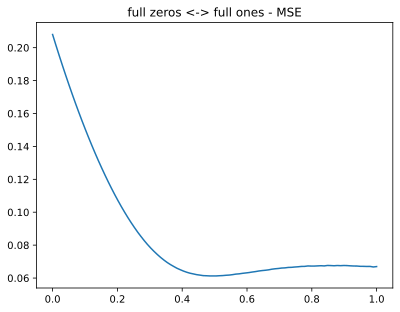

In [27]:
params_1 = {
    OPT_ROUGH_KEY: mi.TensorXf(np.zeros((512, 512, 1))),
    OPT_ENVLIGHT_KEY: mi.TensorXf(np.zeros((256, 513, 4))),
}
params_2 = {
    OPT_ROUGH_KEY: mi.TensorXf(np.ones((512, 512, 1))),
    OPT_ENVLIGHT_KEY: mi.TensorXf(np.ones((256, 513, 4))),
}
plot_loss_linear_interp_1D(Scene.COND2, params_1, params_2, title="full zeros <-> full ones - MSE", loss_fn=mse)

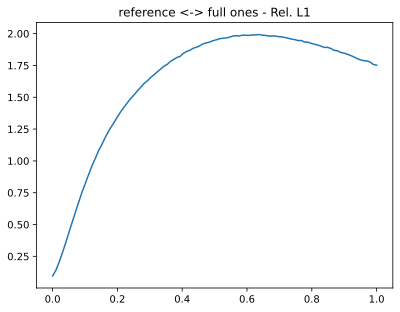

In [28]:
params_1 = {
    OPT_ROUGH_KEY: mi.TensorXf(params_rough_ref[Scene.COND2]),
    OPT_ENVLIGHT_KEY: mi.TensorXf(params_envlight_ref[Scene.COND2]),
}
params_2 = {
    OPT_ROUGH_KEY: mi.TensorXf(np.ones((512, 512, 1))),
    OPT_ENVLIGHT_KEY: mi.TensorXf(np.ones((256, 513, 4))),
}
plot_loss_linear_interp_1D(Scene.COND2, params_1, params_2, title="reference <-> full ones - Rel. L1", loss_fn=rel_l1_loss)

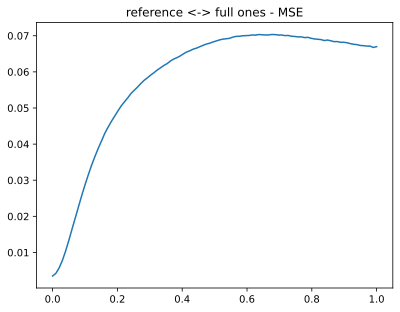

In [29]:
params_1 = {
    OPT_ROUGH_KEY: mi.TensorXf(params_rough_ref[Scene.COND2]),
    OPT_ENVLIGHT_KEY: mi.TensorXf(params_envlight_ref[Scene.COND2]),
}
params_2 = {
    OPT_ROUGH_KEY: mi.TensorXf(np.ones((512, 512, 1))),
    OPT_ENVLIGHT_KEY: mi.TensorXf(np.ones((256, 513, 4))),
}
plot_loss_linear_interp_1D(Scene.COND2, params_1, params_2, title="reference <-> full ones - MSE", loss_fn=mse)

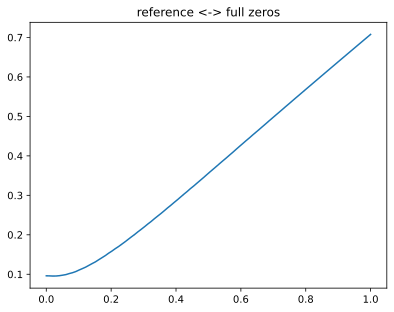

In [30]:
params_1 = {
    OPT_ROUGH_KEY: mi.TensorXf(params_rough_ref[Scene.COND2]),
    OPT_ENVLIGHT_KEY: mi.TensorXf(params_envlight_ref[Scene.COND2]),
}
params_2 = {
    OPT_ROUGH_KEY: mi.TensorXf(np.zeros((512, 512, 1))),
    OPT_ENVLIGHT_KEY: mi.TensorXf(np.zeros((256, 513, 4))),
}
plot_loss_linear_interp_1D(Scene.COND2, params_1, params_2, title="reference <-> full zeros")

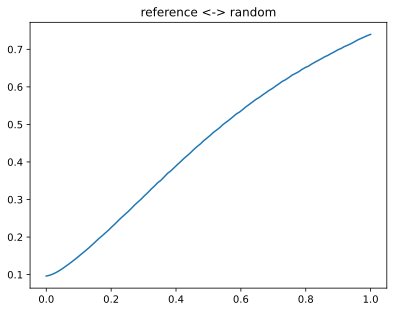

In [31]:
params_1 = {
    OPT_ROUGH_KEY: mi.TensorXf(params_rough_ref[Scene.COND2]),
    OPT_ENVLIGHT_KEY: mi.TensorXf(params_envlight_ref[Scene.COND2]),
}
params_2 = generate_rand_init_values(Scene.COND2, seed=0)
plot_loss_linear_interp_1D(Scene.COND2, params_1, params_2, title="reference <-> random")

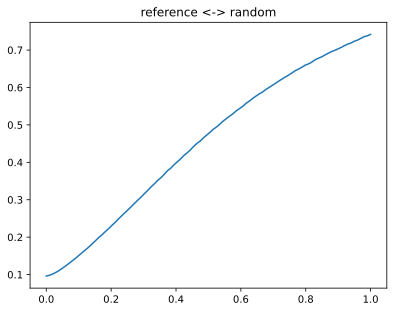

In [32]:
params_1 = {
    OPT_ROUGH_KEY: mi.TensorXf(params_rough_ref[Scene.COND2]),
    OPT_ENVLIGHT_KEY: mi.TensorXf(params_envlight_ref[Scene.COND2]),
}
params_2 = generate_rand_init_values(Scene.COND2, seed=1)
plot_loss_linear_interp_1D(Scene.COND2, params_1, params_2, title="reference <-> random")

# Contour plot experiments

Scene 1

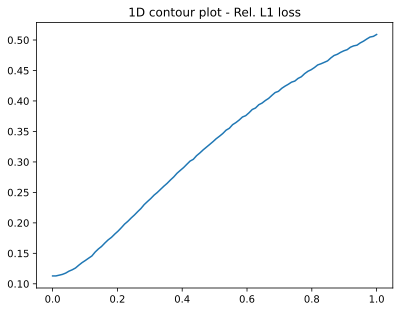

In [33]:
params = {
    OPT_ROUGH_KEY: mi.TensorXf(params_rough_ref[Scene.COND1]),
    OPT_ENVLIGHT_KEY: mi.TensorXf(params_envlight_ref[Scene.COND1]),
}
dir = {
    OPT_ROUGH_KEY: 0.2*mi.TensorXf(np.ones((512, 512, 1))),
    OPT_ENVLIGHT_KEY: 0.2*mi.TensorXf(np.ones((256, 513, 4))),
}
contour_plot_1d(Scene.COND1, params, dir, title="1D contour plot - Rel. L1 loss", loss_fn=rel_l1_loss)

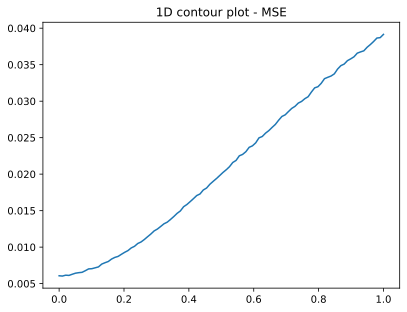

In [34]:
params = {
    OPT_ROUGH_KEY: mi.TensorXf(params_rough_ref[Scene.COND1]),
    OPT_ENVLIGHT_KEY: mi.TensorXf(params_envlight_ref[Scene.COND1]),
}
dir = {
    OPT_ROUGH_KEY: 0.2*mi.TensorXf(np.ones((512, 512, 1))),
    OPT_ENVLIGHT_KEY: 0.2*mi.TensorXf(np.ones((256, 513, 4))),
}
contour_plot_1d(Scene.COND1, params, dir, title="1D contour plot - MSE", loss_fn=mse)

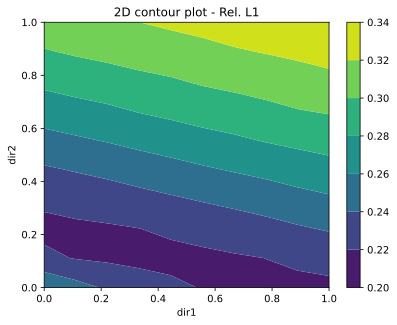

In [35]:
params = {
    OPT_ROUGH_KEY: mi.TensorXf(params_rough_ref[Scene.COND1]),
    OPT_ENVLIGHT_KEY: mi.TensorXf(params_envlight_ref[Scene.COND1]),
}
dir1 = {
    OPT_ROUGH_KEY: 0.2*mi.TensorXf(np.ones((512, 512, 1))),
    OPT_ENVLIGHT_KEY: 0.2*mi.TensorXf(np.ones((256, 513, 4))),
}
dir2 = {
    OPT_ROUGH_KEY: 0.2*generate_rand_rough_tex(Scene.COND1, seed=0),
    OPT_ENVLIGHT_KEY: 0.2*generate_rand_envlight(Scene.COND1, seed=0),
}
contour_plot_2d(Scene.COND1, params, dir1, dir2, title="2D contour plot - Rel. L1", loss_fn=rel_l1_loss)

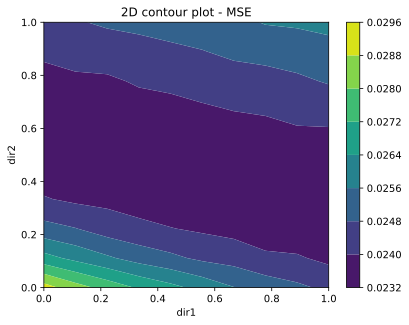

In [36]:
params = {
    OPT_ROUGH_KEY: mi.TensorXf(params_rough_ref[Scene.COND1]),
    OPT_ENVLIGHT_KEY: mi.TensorXf(params_envlight_ref[Scene.COND1]),
}
dir1 = {
    OPT_ROUGH_KEY: 0.2*mi.TensorXf(np.ones((512, 512, 1))),
    OPT_ENVLIGHT_KEY: 0.2*mi.TensorXf(np.ones((256, 513, 4))),
}
dir2 = {
    OPT_ROUGH_KEY: 0.2*generate_rand_rough_tex(Scene.COND1, seed=0),
    OPT_ENVLIGHT_KEY: 0.2*generate_rand_envlight(Scene.COND1, seed=0),
}
contour_plot_2d(Scene.COND1, params, dir1, dir2, title="2D contour plot - MSE", loss_fn=mse)

Scene 2

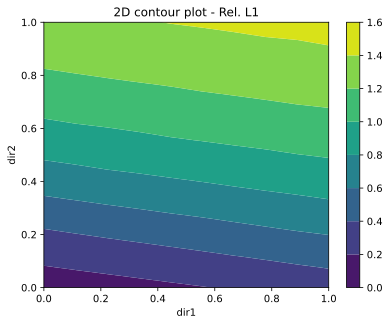

In [37]:
params = {
    OPT_ROUGH_KEY: mi.TensorXf(params_rough_ref[Scene.COND2]),
    OPT_ENVLIGHT_KEY: mi.TensorXf(params_envlight_ref[Scene.COND2]),
}
dir1 = {
    OPT_ROUGH_KEY: 0.2*mi.TensorXf(np.ones((512, 512, 1))),
    OPT_ENVLIGHT_KEY: 0.2*mi.TensorXf(np.ones((256, 513, 4))),
}
dir2 = {
    OPT_ROUGH_KEY: 0.2*generate_rand_rough_tex(Scene.COND2, seed=0),
    OPT_ENVLIGHT_KEY: 0.2*generate_rand_envlight(Scene.COND2, seed=0),
}
contour_plot_2d(Scene.COND2, params, dir1, dir2, title="2D contour plot - Rel. L1", loss_fn=rel_l1_loss)

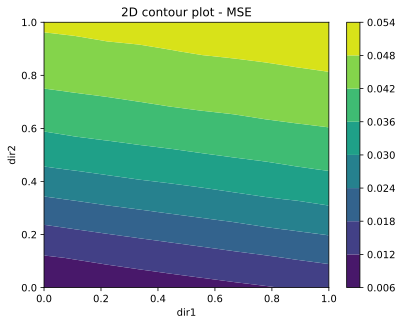

In [38]:
params = {
    OPT_ROUGH_KEY: mi.TensorXf(params_rough_ref[Scene.COND2]),
    OPT_ENVLIGHT_KEY: mi.TensorXf(params_envlight_ref[Scene.COND2]),
}
dir1 = {
    OPT_ROUGH_KEY: 0.2*mi.TensorXf(np.ones((512, 512, 1))),
    OPT_ENVLIGHT_KEY: 0.2*mi.TensorXf(np.ones((256, 513, 4))),
}
dir2 = {
    OPT_ROUGH_KEY: 0.2*generate_rand_rough_tex(Scene.COND2, seed=0),
    OPT_ENVLIGHT_KEY: 0.2*generate_rand_envlight(Scene.COND2, seed=0),
}
contour_plot_2d(Scene.COND2, params, dir1, dir2, title="2D contour plot - MSE", loss_fn=mse)

# Bilinear interpolation

Scene 1

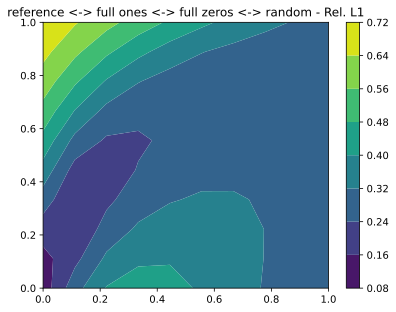

In [39]:
params_1 = {
    OPT_ROUGH_KEY: mi.TensorXf(params_rough_ref[Scene.COND1]),
    OPT_ENVLIGHT_KEY: mi.TensorXf(params_envlight_ref[Scene.COND1]),
}
params_2 = {
    OPT_ROUGH_KEY: mi.TensorXf(np.ones((512, 512, 1))),
    OPT_ENVLIGHT_KEY: mi.TensorXf(np.ones((256, 513, 4))),
}
params_3 = {
    OPT_ROUGH_KEY: mi.TensorXf(np.zeros((512, 512, 1))),
    OPT_ENVLIGHT_KEY: mi.TensorXf(np.zeros((256, 513, 4))),
}
params_4 = {
    OPT_ROUGH_KEY: generate_rand_rough_tex(Scene.COND1, seed=0),
    OPT_ENVLIGHT_KEY: generate_rand_envlight(Scene.COND1, seed=0),
}
plot_loss_bilinear_interp_2D(Scene.COND1, params_1, params_2, params_3, params_4, title="reference <-> full ones <-> full zeros <-> random - Rel. L1", loss_fn=rel_l1_loss)

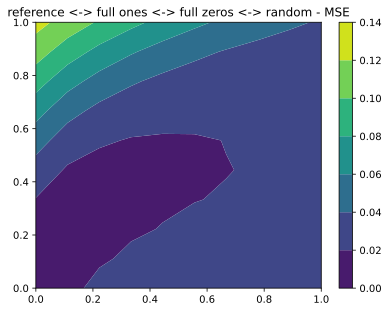

In [40]:
params_1 = {
    OPT_ROUGH_KEY: mi.TensorXf(params_rough_ref[Scene.COND1]),
    OPT_ENVLIGHT_KEY: mi.TensorXf(params_envlight_ref[Scene.COND1]),
}
params_2 = {
    OPT_ROUGH_KEY: mi.TensorXf(np.ones((512, 512, 1))),
    OPT_ENVLIGHT_KEY: mi.TensorXf(np.ones((256, 513, 4))),
}
params_3 = {
    OPT_ROUGH_KEY: mi.TensorXf(np.zeros((512, 512, 1))),
    OPT_ENVLIGHT_KEY: mi.TensorXf(np.zeros((256, 513, 4))),
}
params_4 = {
    OPT_ROUGH_KEY: generate_rand_rough_tex(Scene.COND1, seed=0),
    OPT_ENVLIGHT_KEY: generate_rand_envlight(Scene.COND1, seed=0),
}
plot_loss_bilinear_interp_2D(Scene.COND1, params_1, params_2, params_3, params_4, title="reference <-> full ones <-> full zeros <-> random - MSE", loss_fn=mse)

Scene 2

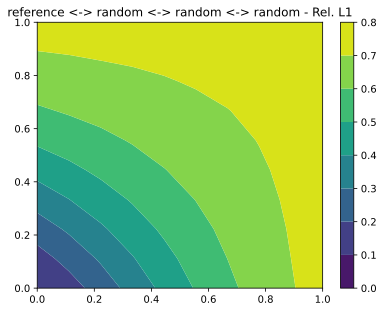

In [41]:
params_1 = {
    OPT_ROUGH_KEY: mi.TensorXf(params_rough_ref[Scene.COND2]),
    OPT_ENVLIGHT_KEY: mi.TensorXf(params_envlight_ref[Scene.COND2]),
}
params_2 = {
    OPT_ROUGH_KEY: generate_rand_rough_tex(Scene.COND2, seed=0),
    OPT_ENVLIGHT_KEY: generate_rand_envlight(Scene.COND2, seed=0),
}
params_3 = {
    OPT_ROUGH_KEY: generate_rand_rough_tex(Scene.COND2, seed=1),
    OPT_ENVLIGHT_KEY: generate_rand_envlight(Scene.COND2, seed=1),
}
params_4 = {
    OPT_ROUGH_KEY: generate_rand_rough_tex(Scene.COND2, seed=2),
    OPT_ENVLIGHT_KEY: generate_rand_envlight(Scene.COND2, seed=2),
}
plot_loss_bilinear_interp_2D(Scene.COND2, params_1, params_2, params_3, params_4, title="reference <-> random <-> random <-> random - Rel. L1", loss_fn=rel_l1_loss)

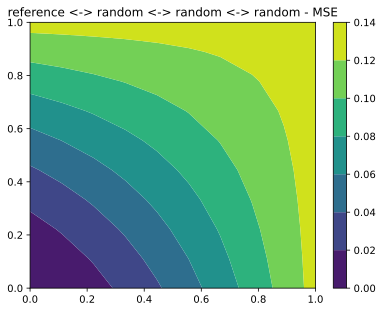

In [42]:
params_1 = {
    OPT_ROUGH_KEY: mi.TensorXf(params_rough_ref[Scene.COND2]),
    OPT_ENVLIGHT_KEY: mi.TensorXf(params_envlight_ref[Scene.COND2]),
}
params_2 = {
    OPT_ROUGH_KEY: generate_rand_rough_tex(Scene.COND2, seed=0),
    OPT_ENVLIGHT_KEY: generate_rand_envlight(Scene.COND2, seed=0),
}
params_3 = {
    OPT_ROUGH_KEY: generate_rand_rough_tex(Scene.COND2, seed=1),
    OPT_ENVLIGHT_KEY: generate_rand_envlight(Scene.COND2, seed=1),
}
params_4 = {
    OPT_ROUGH_KEY: generate_rand_rough_tex(Scene.COND2, seed=2),
    OPT_ENVLIGHT_KEY: generate_rand_envlight(Scene.COND2, seed=2),
}
plot_loss_bilinear_interp_2D(Scene.COND2, params_1, params_2, params_3, params_4, title="reference <-> random <-> random <-> random - MSE", loss_fn=mse)